### Yukawa

In [15]:
import os
import csv
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from qiskit_algorithms import VQE
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA, SLSQP, SPSA
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

In [16]:
optimizer = COBYLA
optimizer_str = 'COBYLA_initial_point'
N = 3

##### Functions

In [17]:
x = sp.Symbol('x')
r = sp.Symbol('r')

# Página 338
def laguerre(j, x):
    f = sp.exp(-x) * x**j
    for n in range(j):
        f = sp.diff(f, x)

    f = sp.exp(x) * f

    globals()[f'L_{j}'] = f

    return sp.simplify(globals()[f'L_{j}'])

# Página 339
def laguerre_associated(n, l, Z):
    j = n-l-1
    k = 2*l+1

    f = laguerre(j+k, x)

    for i in range(k):
        f = sp.diff(f, x)

    globals()[f'L_{j}^{k}'] = (-1)**k * f
    return globals()[f'L_{j}^{k}'].subs(x, 2*r*Z/n)

# Página 347
def radial_wavefunction(n, l, Z):
    """
    Calcula la función de onda radial para un estado dado (n, l) en un átomo con número atómico Z.
    
    Parámetros:
        n (int): Número cuántico principal.
        l (int): Número cuántico azimutal.
        Z (float): Número atómico (número de protones en el núcleo).
    
    Retorna:
        La función de onda radial.
    """
    
    # Polinomio de Laguerre generalizado
    laguerre_poly = laguerre_associated(n, l, Z)
    
    # Factor de normalización
    normalization_factor = sp.sqrt((2*Z/n)**3 * sp.factorial(n-l-1) / (2*n*sp.factorial(n+l)**3))
    
    # Exponencial
    exponential = sp.exp(-Z*r/n)
    
    # Función de onda radial
    radial_wavefunction = normalization_factor * exponential * (2*r*Z/n)**l * laguerre_poly
    
    return radial_wavefunction

https://qiskit-community.github.io/qiskit-nature/stubs/qiskit_nature.second_q.hamiltonians.ElectronicEnergy.html

In [18]:
def hamiltonian_alpha(alpha = 0, N = 3, l = 0):
    h_pq = []

    for i in range(1, N+1):
        h_pq.append([])
        for j in range(1, N+1):
            globals()[f'h_{i}{j}'] = -1/2 * sp.integrate(globals()[f'u_{i}0']*globals()[f'dd_u_{j}0'], (r, 0, sp.oo)) \
                                    - sp.integrate(globals()[f'u_{i}0']*globals()[f'u_{j}0'] * Z*sp.exp(-alpha*r)/r, (r, 0, sp.oo))
            h_pq[i-1].append(globals()[f'h_{i}{j}'])

    size = len(h_pq)
    h1_a = np.array(h_pq, dtype=float)
    h2_aa = np.zeros((size, size, size, size))
    hamiltonian = ElectronicEnergy.from_raw_integrals(h1_a, h2_aa)
    
    return hamiltonian

In [19]:
def save_csv(folder, name, data):
    alphas = data[0]
    energies = data[1]

    if not os.path.exists(folder):
        os.makedirs(folder)

    nombre_archivo = f'{name}.csv'
    ruta_archivo = os.path.join(folder, nombre_archivo)

    with open(ruta_archivo, mode='w', newline='') as archivo_csv:
        escritor_csv = csv.writer(archivo_csv)
        escritor_csv.writerow(['alpha', 'energy'])
        for x, y in zip(alphas, energies):
            escritor_csv.writerow([x, y])

##### The Radial Wavefunction Solutions

In [20]:
Z = 1
n_max = 8
r = sp.Symbol('r')

for n in range(1, n_max+1):
    for l in range(n):
        globals()[f'u_{n}{l}'] = r * radial_wavefunction(n, l, Z)
        globals()[f'dd_u_{n}{l}'] = sp.diff(globals()[f'u_{n}{l}'], r, r)

##### Barrido de alpha

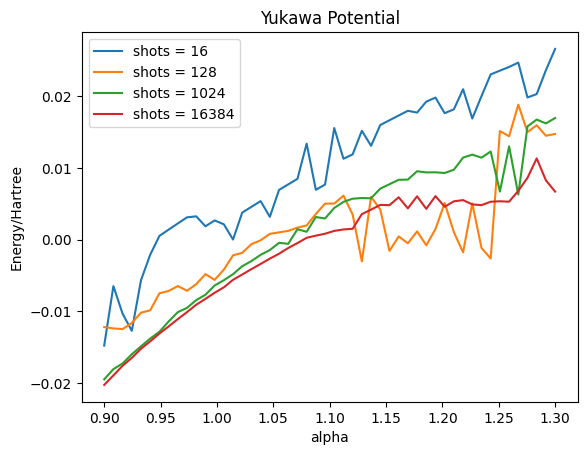

In [21]:
alphas = np.linspace(0.9, 1.3, 50)
shots = [16, 128, 1024, 16384]

for shot in shots:
    energies = []

    hamiltonian = hamiltonian_alpha(0, N)

    mapper = JordanWignerMapper()
    fermionic_op = hamiltonian.second_q_op()
    qubit_op = mapper.map(fermionic_op)

    num_spatial_orbitals = int(fermionic_op.num_spin_orbitals/2)
    # The tuple of the number of alpha- and beta-spin particles
    num_particles = (1, 0)

    ansatz = UCCSD(
        num_spatial_orbitals,
        num_particles,
        mapper,
        initial_state=HartreeFock(
            num_spatial_orbitals,
            num_particles,
            mapper,
        ),
    )

    seed = 170
    algorithm_globals.random_seed = seed

    noiseless_estimator = AerEstimator(
        run_options={"seed": seed, "shots": shot},
        transpile_options={"seed_transpiler": seed},
    )

    vqe_solver = VQE(noiseless_estimator, ansatz, optimizer(maxiter=100))
    vqe_solver.initial_point = np.zeros(ansatz.num_parameters)

    for alpha in alphas:
        hamiltonian = hamiltonian_alpha(alpha, N)

        mapper = JordanWignerMapper()
        fermionic_op = hamiltonian.second_q_op()
        qubit_op = mapper.map(fermionic_op)
        
        eigenvalue = vqe_solver.compute_minimum_eigenvalue(operator=qubit_op).eigenvalue
        energies.append(eigenvalue)

    save_csv(f'results_{optimizer_str}', f'shots={shot}', [alphas, energies])
    plt.plot(alphas, energies, marker='', linestyle='-', label=f'shots = {shot}')

plt.xlabel('alpha')
plt.ylabel('Energy/Hartree')
plt.title('Yukawa Potential')
plt.legend()
plt.savefig(f'results_{optimizer_str}/yukawa_potential')
plt.show()